In [1]:
import copy
import time
import time
import numpy as np
import argparse

from torch.utils import data

from utils.utils import *
from utils import load_config
from utils.validate import *
from fedlearning.model import *
from fedlearning.dataset import *
from fedlearning.evolve import *
from fedlearning.optimizer import GlobalUpdater, LocalUpdater, get_omegas

In [2]:
config_file = "config_cluster.yaml"
config = load_config(config_file)

logger = init_logger(config)

model = init_model(config, logger)

record = init_record(config, model)

if config.device == "cuda":
    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

--------------------------------------------------------------------------------


In [3]:
# Create user_ids
user_ids = np.arange(0, config.users)

# load the dataset
# dataset object is a dictionary with keys: train_data, test_data, user_with_data
# user_with_data is a dictionary with keys: userID:sampleID
# For example, in the IID setting ID's are just assigned like 0, 1, 2, 3, ...
dataset = assign_user_data(config, logger)
test_images = torch.from_numpy(dataset["test_data"]["images"]).to(config.device)
test_labels = torch.from_numpy(dataset["test_data"]["labels"]).to(config.device)

# tau candidates 
taus = np.array(config.taus)

# Create a dictionary of models for each user
# Same initialization for all users
same_init = False
if same_init:
    model_dict = {model_id: copy.deepcopy(model) for model_id in user_ids}
else:
    model_dict = {model_id: init_model(config, logger) for model_id in user_ids}
# create list to store the training rounds for each user    
model_training_rounds = [0]*config.users


In [4]:
num_participators = int(config.part_rate*config.users) 
participating_users = np.random.choice(user_ids, num_participators-1, replace=False)

# Define function to cluster participants in a given communication round into group
def cluster_participants(cluster_size, participating_users):
        np.random.shuffle(participating_users)
        num_participators = len(participating_users)
        num_clusters = num_participators // cluster_size
        clusters = np.array_split(participating_users, num_clusters)
        return clusters


In [7]:
participating_users

array([242,  18, 217, 282, 254, 252, 166, 289, 127, 135, 218, 134,  38,
        25, 228,  98, 175, 256, 279, 221])

In [8]:
cluster_size = 5
cluster_participants(cluster_size, participating_users)

[array([256,  18, 217, 289, 221]),
 array([228, 252, 242, 279, 134]),
 array([ 38, 218, 166, 254, 135]),
 array([175, 282,  98,  25, 127])]

To do for one comm round, given a cluster, train their models

How it works:
- Weights are aggregated from each cluster to create a shared cluster weight, which is then shared with each model
- Each client creates their jacobian matrix with respect to the shared cluster weight and their local data 
- One client is designated as the "server"
- All clients send their jacobian matrices to the server client
- The server clients creates the NTK matrix by taking pairwise inner products of jacobian matrices. They then perform weight evolution on the shared cluster weight. The best weights are then sent back to the clients

In [9]:
def average_cluster_weights(cluster_ids, model_dict):
    # Average the weights of the models in the cluster
    weight_dict = copy.deepcopy(model_dict[cluster_ids[0]].state_dict())
    weight_aggregator = WeightMod(weight_dict)
    for user_id in cluster_ids[1:]:
        weight_aggregator.add(copy.deepcopy(model_dict[user_id].state_dict()))
    weight_aggregator.mul(1.0/len(cluster_ids))
    return weight_aggregator.state_dict()

In [10]:
def load_cluster_weights(cluster_ids, model_dict, weight_dict):
    # Load the averaged weights to the models in the cluster
    for user_id in cluster_ids:
        model_dict[user_id].load_state_dict(weight_dict)
    return None

In [11]:
def train_cluster(cluster_ids, model_dict, model_training_rounds, verbose=False):
    acc = []
    losses = []
    params_list = []

    global_kernel = None
    global_xs = None
    global_ys = None
    local_packages = []
    local_kernels = []

    global_jac = None

    averaged_weight = average_cluster_weights(cluster_ids, model_dict)
    # Load averaged weight into clusters
    load_cluster_weights(cluster_ids, model_dict, averaged_weight)
    for user_id in cluster_ids:
        # Select the model with which to take jacobian
        model = model_dict[user_id]
        
        if verbose: print("user {:d} updating".format(user_id))
        # assign_user_resource specifies some parameters for the user given their user_id
        # user_resource is a dictionary with keys: lr, device, batch_size, images, labels
        user_resource = assign_user_resource(config, user_id, 
                            dataset["train_data"], dataset["user_with_data"])
        local_updater = LocalUpdater(config, user_resource)
        # Gets the local jacobians for a given client specified in local_updater
        local_updater.local_step(model)
        # Simulate uplink transmission
        local_package = local_updater.uplink_transmit()
        # Append this clients jacobians to the list
        local_packages.append(local_package)

        # Send local x and y
        if global_xs is None:
            global_xs = local_updater.xs
            global_ys = local_updater.ys
        else:
            global_xs = torch.vstack((global_xs, local_updater.xs))
            global_ys = torch.vstack((global_ys, local_updater.ys))            

         # del local_updater
        torch.cuda.empty_cache()

    start_time = time.time()
    global_jac = combine_local_jacobians(local_packages)

    del local_packages
    # Added these two lines to free up memory
    del local_package
    del local_updater

    if verbose: print("compute kernel matrix")
    global_kernel = empirical_kernel(global_jac)

    if verbose: print("kernel computation time {:3f}".format(time.time() - start_time))

    # Returns a function that, given t and f_0, solves for f_t
    predictor = gradient_descent_ce(global_kernel.cpu(), global_ys.cpu(), config.lr)
    
    # This is f^(0) (X)
    # Note: All models in the cluster have the same initial (aggregated) weights, 
    # so they also have the same weight evolution under the NTK
    with torch.no_grad():
        fx_0 = model(global_xs)

    # Configure maximum t as one more than the largest tau value
    t = torch.arange(config.taus[-1]+1)
    
    # Create f_x using the time values and the initial f_x
    fx_train = predictor(t, fx_0.cpu())
    # fx_train = fx_train.to(fx_0)
    
    # Use current weights to pass to the optimizer
    init_state_dict = copy.deepcopy(model.state_dict())

    losses = np.zeros_like(taus, dtype=float)
    acc = np.zeros_like(taus, dtype=float)

    if verbose: print("loss \tacc")
    for i, tau in enumerate(config.taus):
        # initialize the weight aggregator with current weights
        weight_aggregator = WeightMod(init_state_dict)
        global_omegas = get_omegas(t[:tau+1], config.lr, global_jac, 
                global_ys.cpu(), fx_train[:tau+1], config.loss, 
                model.state_dict())
        # global_omegas = get_omegas(t[:tau+1], config.lr, global_jac, 
        #         global_ys, fx_train[:tau+1], config.loss, 
        #         model.state_dict())        
        
        # Complete the sum in 9b
        weight_aggregator.add(global_omegas)
        aggregated_weight = weight_aggregator.state_dict()
        model.load_state_dict(aggregated_weight)

        output = model(global_xs)

        loss = loss_with_output(output, global_ys, config.loss)
        # loss_fx = loss_with_output(fx_train[tau].to(global_ys), global_ys, config.loss)
        losses[i] = loss

        output = model(test_images)

        test_acc = accuracy_with_output(output, test_labels)
        acc[i] = test_acc

        if verbose: print("{:.3f}\t{:.3f}".format(loss, test_acc))

        params_list.append(copy.deepcopy(aggregated_weight))
        
    # Get index of tau with lowest loss
    idx = np.argmin(losses)
    # Select weight parameters with lowest loss
    params = params_list[idx]

    # Select tau with lowest loss
    current_tau = taus[idx]
    current_acc = acc[idx]
    current_loss = losses[idx]

    if verbose: logger.info("current tau {:d}".format(current_tau))
    logger.info("acc {:4f}".format(current_acc))
    if verbose: logger.info("loss {:.4f}".format(current_loss))
    
    # Load weights into models in cluster
    load_cluster_weights(cluster_ids, model_dict, params)
    
    # Increment training round for each model in cluster
    for user_id in cluster_ids:
        model_training_rounds[user_id] += 1
    
    # Return the current loss, accuracy, and tau
    record["loss"].append(current_loss)
    record["testing_accuracy"].append(current_acc)
    record["taus"].append(current_tau)

    torch.cuda.empty_cache()



In [12]:
def get_accuracies(model_ids, model_dict, test_images, test_labels):
    '''
    Get the accuracies of the models in the model_dict specified by the model_ids
    returns a list of accuracies
    '''
    acc = []
    for user_id in model_ids:
        model = model_dict[user_id]
        output = model(test_images)
        test_acc = accuracy_with_output(output, test_labels)
        acc.append(test_acc)
    return acc

In [13]:
comm_rounds = config.rounds
for round in range(comm_rounds):
    logger.info("Comm Round {:d}".format(round))
    # Select participating users
    participating_users = np.random.choice(user_ids, num_participators-1, replace=False)
    # Cluster participating users
    clusters = cluster_participants(cluster_size, participating_users)
    for cluster in clusters:
        train_cluster(cluster, model_dict, model_training_rounds)
    participating_accs = get_accuracies(participating_users, model_dict, test_images, test_labels)
    record["model_accs_per_round"].append(get_accuracies(user_ids, model_dict, test_images, test_labels))
    logger.info(f"Participating Accs: {np.mean(participating_accs)}")
    logger.info("-"*80)
    
# Save model_num_training_rounds
record["model_num_training_rounds"] = model_training_rounds

Comm Round 0
acc 0.619900
acc 0.487500
acc 0.571000
acc 0.557900
Participating Accs: 0.5590749904513359
--------------------------------------------------------------------------------
Comm Round 1
acc 0.657400
acc 0.613400
acc 0.639300
acc 0.562100
Participating Accs: 0.6180499941110611
--------------------------------------------------------------------------------
Comm Round 2
acc 0.582800
acc 0.522600
acc 0.565500
acc 0.538700
Participating Accs: 0.5523999780416489
--------------------------------------------------------------------------------
Comm Round 3
acc 0.652900
acc 0.594900
acc 0.591600
acc 0.557300
Participating Accs: 0.5991749912500381
--------------------------------------------------------------------------------
Comm Round 4
acc 0.641300
acc 0.631600
acc 0.578400
acc 0.633100
Participating Accs: 0.6210999637842178
--------------------------------------------------------------------------------
Comm Round 5
acc 0.708000
acc 0.529800
acc 0.610900
acc 0.602500
Participat

In [14]:
save_record(config, record)

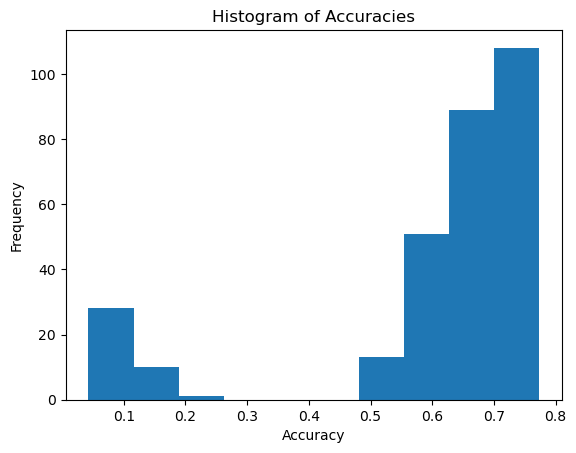

In [15]:
from matplotlib import pyplot as plt
all_accs = get_accuracies(user_ids, model_dict, test_images, test_labels)
plt.hist(all_accs)
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.title("Histogram of Accuracies")
plt.show()

In [16]:
all_accs = np.asarray(all_accs)

accs_under_01 = all_accs[all_accs < 0.1]
accs_under_01

array([0.0731    , 0.076     , 0.0696    , 0.0945    , 0.0428    ,
       0.08679999, 0.091     , 0.0643    , 0.07229999, 0.0517    ,
       0.0902    , 0.0722    , 0.0937    , 0.0553    , 0.0741    ,
       0.0818    , 0.0491    , 0.0979    , 0.0865    , 0.09079999,
       0.0797    , 0.0896    ])

In [17]:
#np.argwhere(0.1 < all_accs).flatten()
np.argwhere((all_accs >= 0.2) & (all_accs <= 0.65)).flatten()

array([  0,   1,   2,   3,   4,  22,  23,  27,  29,  30,  40,  45,  51,
        53,  56,  59,  60,  61,  62,  70,  74,  78,  79,  80,  81,  85,
        90,  91, 105, 108, 109, 115, 116, 118, 125, 129, 134, 138, 145,
       153, 155, 156, 161, 163, 164, 165, 167, 173, 178, 184, 186, 194,
       199, 207, 211, 212, 216, 221, 224, 227, 232, 238, 242, 243, 244,
       248, 249, 255, 263, 264, 267, 269, 273, 281, 284, 286, 288, 292,
       294, 296, 297, 298])

In [18]:
np.argwhere(np.array(model_training_rounds)==1).flatten()

array([  0,   1,   2,   3,   4,   7,   8,  11,  13,  22,  29,  37,  45,
        48,  49,  51,  53,  54,  59,  61,  73,  75,  77,  79,  80,  81,
        85,  88,  89,  90,  91,  93, 100, 103, 108, 109, 113, 117, 118,
       120, 124, 125, 126, 127, 129, 135, 145, 155, 163, 164, 171, 172,
       173, 184, 186, 189, 190, 194, 195, 198, 199, 201, 202, 210, 211,
       212, 226, 227, 243, 244, 263, 264, 267, 272, 273, 274, 275, 276,
       281, 283, 284, 285, 288, 289, 291, 292, 294, 298])

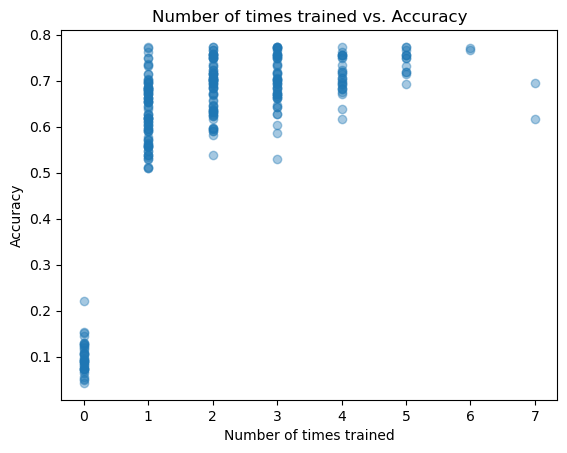

In [19]:
num_times_trained = np.array(model_training_rounds)
plt.scatter(x=num_times_trained, y=all_accs, alpha=0.4)
plt.xlabel("Number of times trained")
plt.ylabel("Accuracy")
plt.title("Number of times trained vs. Accuracy")
plt.show()

Animation.save using <class 'matplotlib.animation.HTMLWriter'>


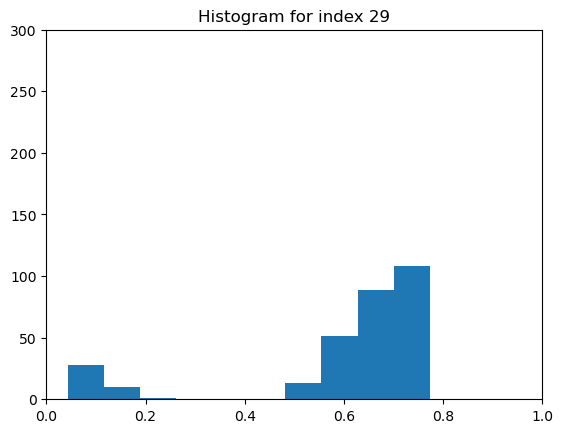

In [20]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

def plot_histogram_evolution(record):
    fig, ax = plt.subplots()

    def update_hist(num):
        ax.clear()
        ax.hist(record["model_accs_per_round"][num])
        ax.set_title(f'Histogram for index {num}')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 300)

    ani = animation.FuncAnimation(fig, update_hist, frames=range(30), repeat=False)

    # To display the animation in Jupyter Notebook
    HTML(ani.to_jshtml())
plot_histogram_evolution(record)